In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_formation(positions, neighbors):
    """
    Plot agent positions and edges between neighbors.

    Parameters:
        positions (dict): Dictionary containing the positions of agents {i: [x, y]}.
        neighbors (dict): Dictionary of neighbors for each agent {i: [j1, j2, ...]}.
    """
    # Create a new plot
    plt.figure(figsize=(8, 8))
    
    # Plot agents
    for i, pos in positions.items():
        plt.scatter(pos[0], pos[1], label=f"Agent {i}", s=100, color='red')  # Agent position
        plt.text(pos[0] + 0.05, pos[1] + 0.05, f"{i}", fontsize=12, color='blue')  # Label agent
        
    # Plot edges
    for i, neighbor_list in neighbors.items():
        for j in neighbor_list:
            # Draw a line between agent i and agent j
            pos_i = positions[i]
            pos_j = positions[j]
            plt.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], 'k-', alpha=0.4)  # Edge between agents
    
    # Plot settings
    plt.title("Agent Formation")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.axis('equal')
    plt.grid(True)
    #plt.legend()
    plt.show()
    return



def compute_g_star(positions, neighbors):
    """
    Compute the desired bearings g_star for a formation.

    Parameters:
        positions (dict): Dictionary containing the positions of agents {i: [x, y]}.
        neighbors (dict): Dictionary of neighbors for each agent {i: [j1, j2, ...]}.

    Returns:
        dict: Desired bearings { (i, j): g_ij_star }.
    """
    g_star = {}

    for i, neighbor_list in neighbors.items():
        for j in neighbor_list:
            # Compute the relative position
            diff = np.array(positions[j]) - np.array(positions[i])
            
            # Normalize to obtain the bearing vector
            g_star[(i, j)] = diff / np.linalg.norm(diff)
    
    return g_star

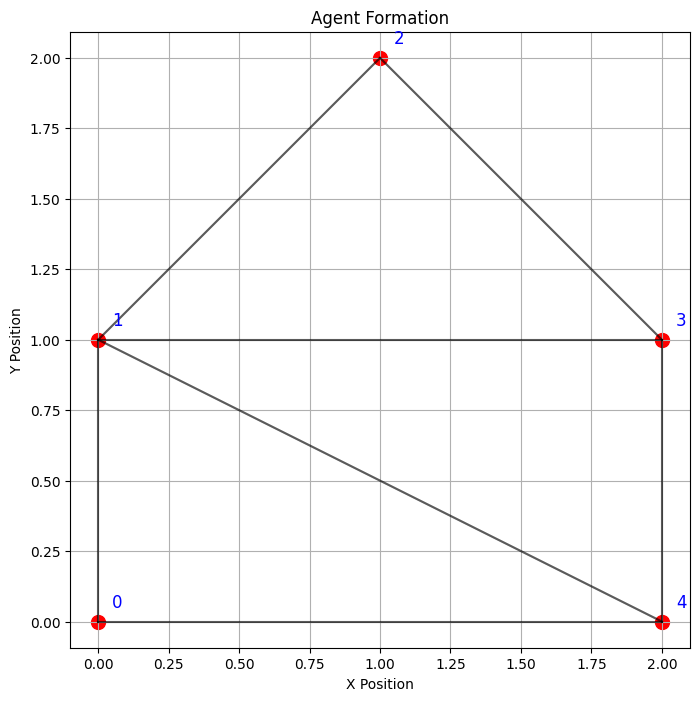

In [19]:
# Number of agents
num_agents = 5
leaders = [0, 1]  # Agents 0 and 1 are leaders
n_leaders = len(leaders)
leader_velocity = 0.05
k_p = 1.0
k_h = 0.5
neighbors = {
    0: [1, 4],
    1: [0, 2, 3, 4],
    2: [1, 3],
    3: [1, 2, 4],
    4: [0, 1, 3]
}
positions = {
    0: [0.0, 0.0],
    1: [0.0, 1.0],
    2: [1.0, 2.0],
    3: [2.0, 1.0],
    4: [2.0, 0.0]
}
plot_formation(positions, neighbors)
g_star = compute_g_star(positions, neighbors)

In [31]:
# Parameters
dt = 0.01  # Time step
T = 90     # Total simulation time
steps = int(T / dt)
# Initialize states
positions = np.array([
    [0.0, 0.0], 
    [0.0, 1.0], 
    [-1.1, 2.1], 
    [2.2, 1.5], 
    [2.5, 0.6]])
# positions = np.array([
#     [0.0, 0.0],
#     [0.0, 1.0],
#     [1.0, 2.0],
#     [2.0, 1.0],
#     [2.0, 0.0]]
# )

k_p = 8.  # Proportional gain for velocity
k_h = 8.0  # Proportional gain for angular velocity
headings = np.array([0.4, 0.4, 0.4, 0.4, 0.4])
velocities = np.zeros(num_agents)
angular_velocities = np.zeros(num_agents)


# Simulation
trajectories = [positions.copy()]
for step in range(steps):
    new_positions = positions.copy()
    new_headings = headings.copy()

    for i in range(num_agents):
        h_i = np.array([np.cos(headings[i]), np.sin(headings[i])])
        h_i_perp = np.array([-np.sin(headings[i]), np.cos(headings[i])])
        p_i = positions[i]

        if i < n_leaders:  # Leader agents
            velocities[i] = leader_velocity
            angular_velocities[i] = 0
        else:  # Follower agents
            control_sum = np.zeros(2)
            for j in neighbors[i]:  # Use neighbors dictionary
                p_j = positions[j]
                g_ij = (p_j - p_i) / np.linalg.norm(p_j - p_i)
                g_ij_star = g_star.get((i, j), np.zeros(2))
                control_sum += g_ij - g_ij_star

            v_c = np.zeros(2)  # Can be modified for group motion
            velocities[i] = h_i @ (k_p * control_sum + v_c)
            angular_velocities[i] = h_i_perp @ (k_h * control_sum + v_c)

        # Update states
        new_positions[i] += dt * velocities[i] * h_i
        new_headings[i] += dt * angular_velocities[i]

    positions = new_positions
    headings = new_headings
    trajectories.append(positions.copy())

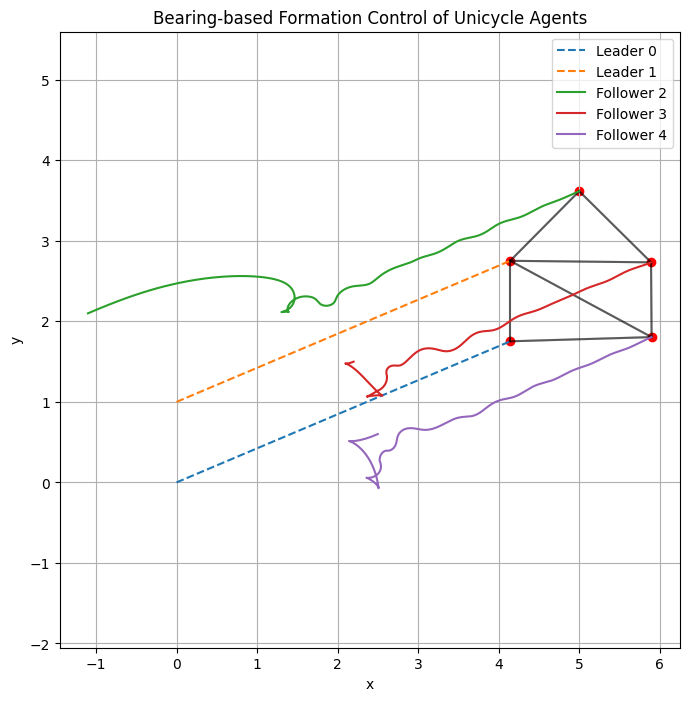

In [37]:
# Plot results
trajectories = np.array(trajectories)
plt.figure(figsize=(8, 8))
for i, neighbor_list in neighbors.items():
    for j in neighbor_list:
        pos_i = positions[i]
        pos_j = positions[j]
        plt.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], 'k-', alpha=0.4)
for i in range(n_leaders):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1],'--', label=f"Leader {i}")
for i in range(n_leaders, num_agents):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], label=f"Follower {i}")
    # Plot edges corresponding to the neighbors at the final position

plt.scatter(positions[:, 0], positions[:, 1], c='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Bearing-based Formation Control of Unicycle Agents")
plt.grid()
plt.axis('equal')
plt.savefig("unicycle.svg")
plt.show()